In [113]:
! pip3 install lightgbm

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
# from lightgbm import LGBMRegressor

In [80]:
train = pd.read_csv("./open/train.csv")
test = pd.read_csv("./open/test.csv")

In [3]:
train.head()

,id,temperature,pressure,humidity,wind_speed,wind_direction,precipitation,snowing,cloudiness,target
0,TRAIN_00000,27.8816,1013.6,46.8,2.4,232.4,0.00,False,0.0,1.180
1,TRAIN_00001,5.7540,1026.6,76.6,3.6,172.0,0.00,False,8.8,8.581
2,TRAIN_00002,20.8220,1016.2,64.8,2.2,206.0,0.06,False,23.0,3.978
3,TRAIN_00003,20.0758,1017.4,72.6,0.8,215.4,0.00,False,0.0,8.301
4,TRAIN_00004,7.5260,1023.2,82.8,1.2,158.0,0.00,False,15.0,1.692


In [4]:
test.head()

,id,temperature,pressure,humidity,wind_speed,wind_direction,precipitation,snowing,cloudiness
0,TEST_00000,20.702000,1021.0,76.4,2.0,104.8,0.00,False,23.0
1,TEST_00001,18.673669,1014.4,59.6,2.4,179.2,0.12,False,32.4
2,TEST_00002,29.908000,1020.6,49.6,2.6,78.0,0.60,False,23.0
3,TEST_00003,24.504000,1014.6,61.0,1.8,118.0,0.00,False,15.0
4,TEST_00004,12.590000,1011.4,70.8,1.8,110.0,0.12,False,34.0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19275 entries, 0 to 19274
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              19275 non-null  object 
 1   temperature     19275 non-null  float64
 2   pressure        19275 non-null  float64
 3   humidity        19275 non-null  float64
 4   wind_speed      19275 non-null  float64
 5   wind_direction  19275 non-null  float64
 6   precipitation   19275 non-null  float64
 7   snowing         19275 non-null  bool   
 8   cloudiness      19275 non-null  float64
 9   target          19275 non-null  float64
dtypes: bool(1), float64(8), object(1)
memory usage: 1.3+ MB


In [90]:
input_var = ['temperature','pressure','humidity','wind_speed','wind_direction','precipitation','snowing','cloudiness']

# 데이터 구조 확인하기

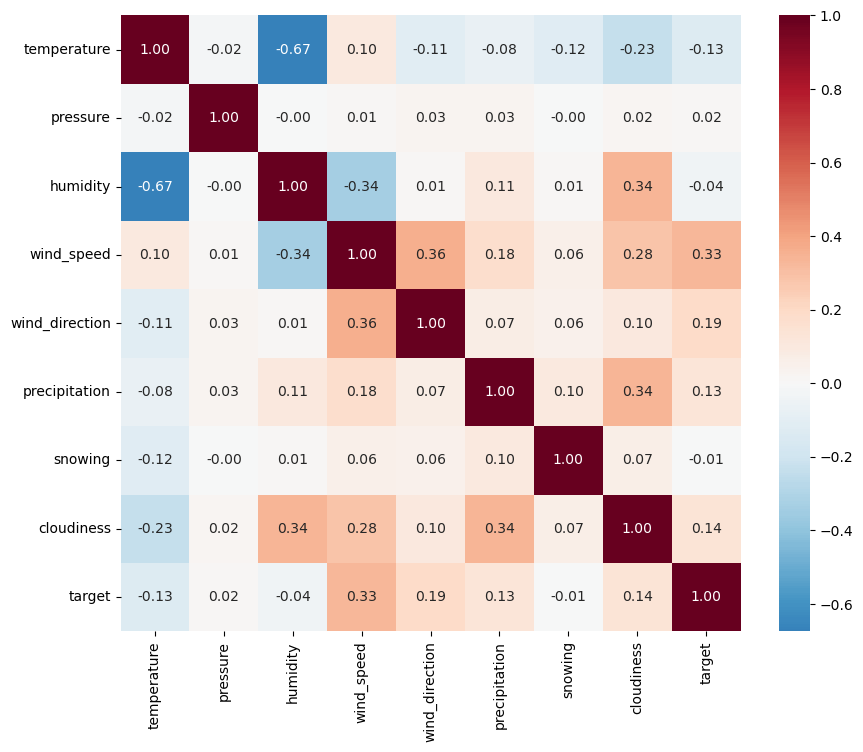

In [40]:
# 상관성 확인하기
plt.figure(figsize = (10,8))
sns.heatmap(train.drop(columns=['id'], axis=1).corr(),
           annot = True, fmt = '.2f', cmap = 'RdBu_r', center = 0)
plt.show()

 -> 상관성이 높은 1쌍 (temperature, humidity)

In [41]:
# del train['humidity'] # target과 상관성이 더 낮은 변수 'humidity' 제거 (제거 안하는 게 MSE 더 낮음)

In [42]:
# input_var = ['temperature','pressure','wind_speed','wind_direction','precipitation','snowing','cloudiness']

/Users/minjeekim/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/minjeekim/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/minjeekim/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


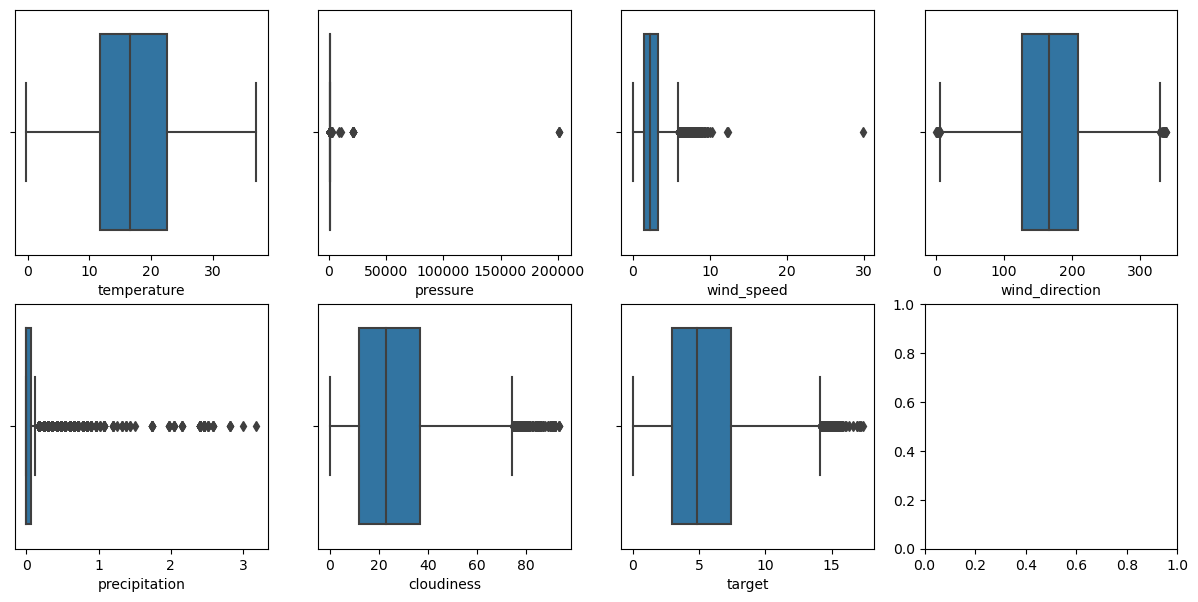

In [43]:
# 이상치 확인하기
fig, axes = plt.subplots(2,4, figsize=(15,7))
a=0;b=0

sns.boxplot(train['temperature'], ax = axes[0][0])
sns.boxplot(train['pressure'], ax = axes[0][1])
sns.boxplot(train['wind_speed'], ax = axes[0][2])
sns.boxplot(train['wind_direction'], ax = axes[0][3])
sns.boxplot(train['precipitation'], ax = axes[1][0])
sns.boxplot(train['cloudiness'], ax = axes[1][1])
sns.boxplot(train['target'], ax = axes[1][2])

plt.show()

In [81]:
## 이상치를 전부 제거하면 데이터가 많이 삭제되기 때문에 좋지않음! target과 가장 상관성이 높은 wind_speed의 이상치를 제거
Q1 = train.describe().loc['25%']
Q3 = train.describe().loc['75%']
IQR = Q3 - Q1
u = Q3 + 1.5 * IQR
l = Q1 - 1.5 * IQR
outline = pd.DataFrame({'lower':l, 'upper':u})
outline

,lower,upper
temperature,-4.55850,38.82950
pressure,1000.00000,1033.60000
humidity,23.30000,115.30000
wind_speed,-1.30000,5.90000
wind_direction,5.50000,329.50000
precipitation,-0.09000,0.15000
cloudiness,-25.50000,74.50000
target,-3.76475,14.15725


In [82]:
index = train[(train['wind_speed']<=outline.loc['wind_speed','lower']) | (train['wind_speed'] >= outline.loc['wind_speed','upper'])].index

In [83]:
t = train.copy()
t

,id,temperature,pressure,humidity,wind_speed,wind_direction,precipitation,snowing,cloudiness,target
0,TRAIN_00000,27.881600,1013.6,46.8,2.4,232.4,0.00,False,0.0,1.180
1,TRAIN_00001,5.754000,1026.6,76.6,3.6,172.0,0.00,False,8.8,8.581
2,TRAIN_00002,20.822000,1016.2,64.8,2.2,206.0,0.06,False,23.0,3.978
3,TRAIN_00003,20.075800,1017.4,72.6,0.8,215.4,0.00,False,0.0,8.301
4,TRAIN_00004,7.526000,1023.2,82.8,1.2,158.0,0.00,False,15.0,1.692
...,...,...,...,...,...,...,...,...,...,...
19270,TRAIN_19270,12.020000,1023.8,81.4,1.6,176.0,0.00,False,0.0,7.047
19271,TRAIN_19271,17.232000,993.2,78.2,2.0,198.0,0.06,False,26.4,3.670
19272,TRAIN_19272,13.748000,999.8,65.0,6.4,260.0,0.36,False,53.0,3.328
19273,TRAIN_19273,19.354000,1019.4,45.4,2.4,120.0,0.06,False,20.0,12.379


In [84]:
t = t.drop(index, axis = 0)

In [85]:
t

,id,temperature,pressure,humidity,wind_speed,wind_direction,precipitation,snowing,cloudiness,target
0,TRAIN_00000,27.881600,1013.6,46.8,2.4,232.4,0.00,False,0.0,1.180
1,TRAIN_00001,5.754000,1026.6,76.6,3.6,172.0,0.00,False,8.8,8.581
2,TRAIN_00002,20.822000,1016.2,64.8,2.2,206.0,0.06,False,23.0,3.978
3,TRAIN_00003,20.075800,1017.4,72.6,0.8,215.4,0.00,False,0.0,8.301
4,TRAIN_00004,7.526000,1023.2,82.8,1.2,158.0,0.00,False,15.0,1.692
...,...,...,...,...,...,...,...,...,...,...
19269,TRAIN_19269,30.234000,1016.2,45.6,4.6,186.0,0.00,False,23.0,6.500
19270,TRAIN_19270,12.020000,1023.8,81.4,1.6,176.0,0.00,False,0.0,7.047
19271,TRAIN_19271,17.232000,993.2,78.2,2.0,198.0,0.06,False,26.4,3.670
19273,TRAIN_19273,19.354000,1019.4,45.4,2.4,120.0,0.06,False,20.0,12.379


# XGBOOST 모델링

In [96]:
xgb = XGBRegressor(n_estimators=300, learning_rate=0.1)
xgb.fit(t[input_var], t['target'])
t['pred'] = xgb.predict(t[input_var])
abs(t['target']-t['pred']).mean()

1.6134315547652904

In [97]:
xgb2 = XGBRegressor(n_estimators=300, learning_rate=0.1)
xgb2.fit(train[input_var],train['target'])
train['pred'] = xgb2.predict(train[input_var])
abs(train['target']-train['pred']).mean()

1.655445777241361

-> 이상치 제거했을 때 예측 더 잘됨

In [98]:
# 변수중요도가 큰 순으로 input variables
imt = pd.DataFrame({'var':input_var, 'import':xgb.feature_importances_}).sort_values(by='import',ascending=False)
imt

,var,import
3,wind_speed,0.262400
6,snowing,0.186836
5,precipitation,0.098725
0,temperature,0.097704
1,pressure,0.095233
7,cloudiness,0.087725
4,wind_direction,0.086764
2,humidity,0.084613


<function matplotlib.pyplot.show(close=None, block=None)>

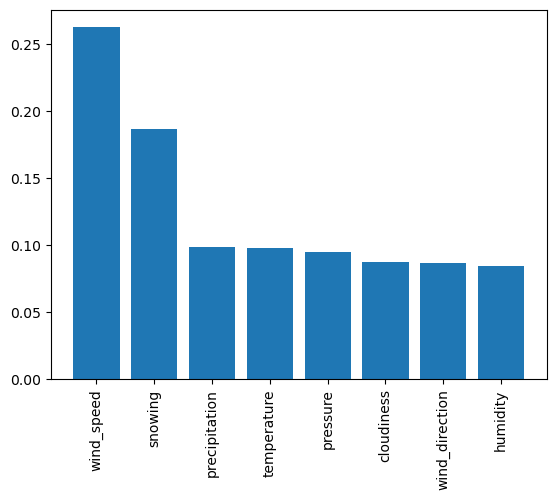

In [99]:
plt.bar(imt['var'], imt['import'])
plt.xticks(rotation=90)
plt.show

# 파라미터 조정

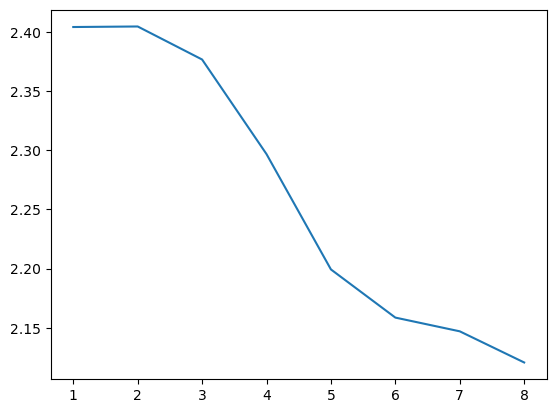

In [101]:
# input 변수 개수는 몇 개가 좋을 지?
score_list = [] # MAE 점수 리스트
varnum = [] # input variables 개수 리스트

for i in range(1,len(imt)+1):
    select_var = imt['var'].iloc[:i].to_list()
    scores = cross_val_score(xgb, t[select_var], t['target'], scoring = 'neg_mean_absolute_error', cv = 3)
    score_list.append(-scores.mean())
    varnum.append(i)
    
plt.plot(varnum, score_list) 

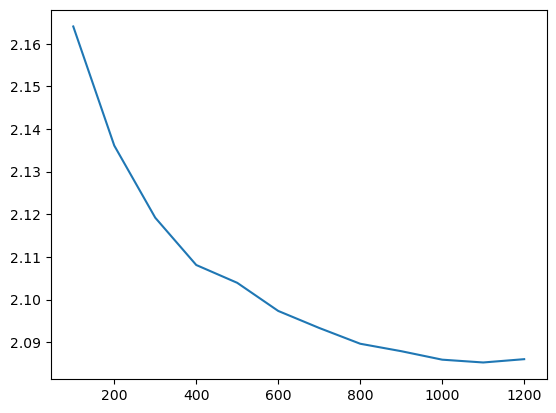

In [130]:
# 파라미터는 몇이 좋을지?
estimators_list = [100,200,300,400,500,600,700,800,900,1000,1100,1200]
score_list = []

for i in estimators_list:
    xgb = XGBRegressor(n_estimators=i, learning_rate=0.1)
    scores = cross_val_score(xgb, t[input_var], t['target'], scoring = 'neg_mean_absolute_error', cv = 3)
    score_list.append(-scores.mean())

plt.plot(estimators_list, score_list)

In [104]:
xgb = XGBRegressor(n_estimators=900, learning_rate=0.1)
xgb.fit(t[input_var], t['target'])
t['pred'] = xgb.predict(t[input_var])
abs(t['target']-t['pred']).mean()

1.1031250652972757

In [105]:
test['target'] = xgb.predict(test[input_var])
test[['id','target']].to_csv("submission.csv", index = False)

## => 2.0636867776

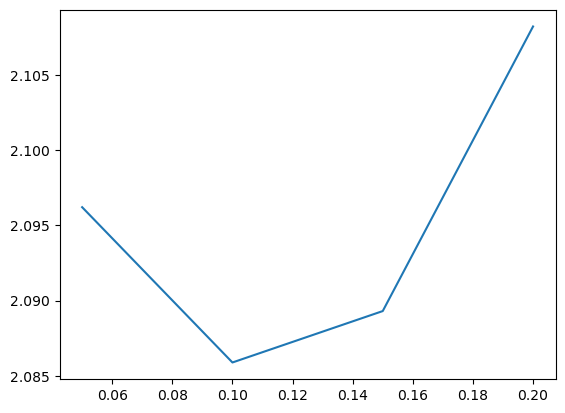

In [133]:
# 파라미터는 몇이 좋을지?
lr_list = [0.05,0.1,0.15,0.2]
score_list = []

for i in lr_list:
    xgb = XGBRegressor(n_estimators=1000, learning_rate=i)
    scores = cross_val_score(xgb, t[input_var], t['target'], scoring = 'neg_mean_absolute_error', cv = 3)
    score_list.append(-scores.mean())

plt.plot(lr_list, score_list)

In [134]:
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.1)
xgb.fit(t[input_var], t['target'])
t['pred'] = xgb.predict(t[input_var])
abs(t['target']-t['pred']).mean()

1.0402363199093154

In [135]:
test['target'] = xgb.predict(test[input_var])
test[['id','target']].to_csv("submission.csv", index = False)

## => 2.0594433004

/Users/minjeekim/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='wind_speed'>

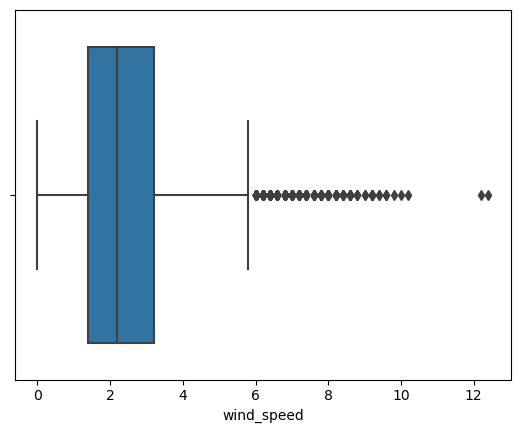

In [147]:
tt = train[train['wind_speed']<=25]
sns.boxplot(tt['wind_speed'])

/Users/minjeekim/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='wind_speed'>

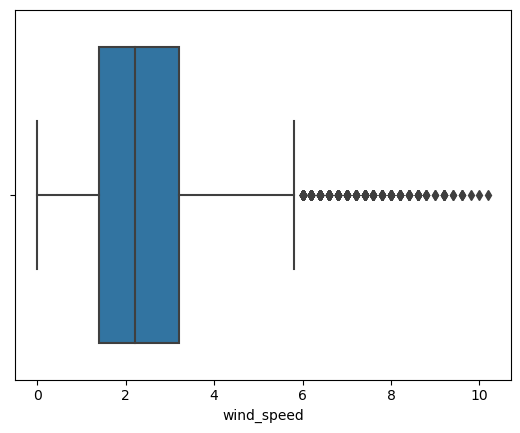

In [148]:
tt = train[train['wind_speed']<12]
sns.boxplot(tt['wind_speed'])

In [149]:
train['wind_speed'].median()

2.2

In [150]:
tt['wind_speed'].median()

2.2

In [151]:
tt['wind_speed'].describe()

count    19272.000000
mean         2.474533
std          1.342002
min          0.000000
25%          1.400000
50%          2.200000
75%          3.200000
max         10.200000
Name: wind_speed, dtype: float64

In [152]:
train['wind_speed'].describe()

count    19275.000000
mean         2.476970
std          1.359942
min          0.000000
25%          1.400000
50%          2.200000
75%          3.200000
max         29.800000
Name: wind_speed, dtype: float64

/Users/minjeekim/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='wind_speed'>

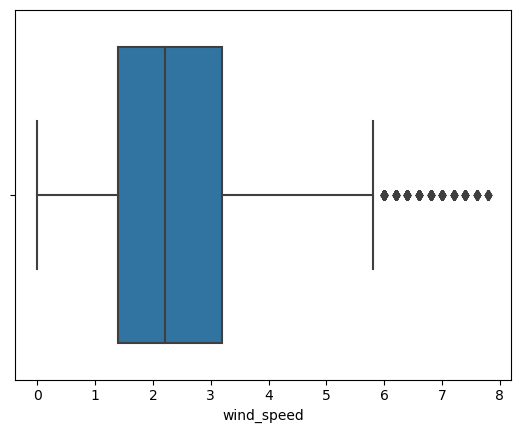

In [153]:
tt = train[train['wind_speed']<8]
sns.boxplot(tt['wind_speed'])

In [154]:
tt['wind_speed'].describe()

count    19201.000000
mean         2.452091
std          1.292198
min          0.000000
25%          1.400000
50%          2.200000
75%          3.200000
max          7.800000
Name: wind_speed, dtype: float64